### TEXT CLASSIFICATION USING NAIVE BAYES AND SENTIMENT ANALYSIS ON BLOG POSTS

#### Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

#### Loading Dataset
##### Load the "blogs.csv" dataset and perform an exploratory data analysis to understand its structure and content

In [3]:
df = pd.read_csv('blogs.csv')
df

,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism
...,...,...
1995,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,talk.religion.misc
1996,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc
1997,Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...,talk.religion.misc
1998,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc


In [4]:
df.shape

(2000, 2)

#### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
df.isnull().sum()

Data      0
Labels    0
dtype: int64

In [7]:
label_counts = df['Labels'].value_counts()
label_counts

Labels
alt.atheism                 100
comp.graphics               100
talk.politics.misc          100
talk.politics.mideast       100
talk.politics.guns          100
soc.religion.christian      100
sci.space                   100
sci.med                     100
sci.electronics             100
sci.crypt                   100
rec.sport.hockey            100
rec.sport.baseball          100
rec.motorcycles             100
rec.autos                   100
misc.forsale                100
comp.windows.x              100
comp.sys.mac.hardware       100
comp.sys.ibm.pc.hardware    100
comp.os.ms-windows.misc     100
talk.religion.misc          100
Name: count, dtype: int64

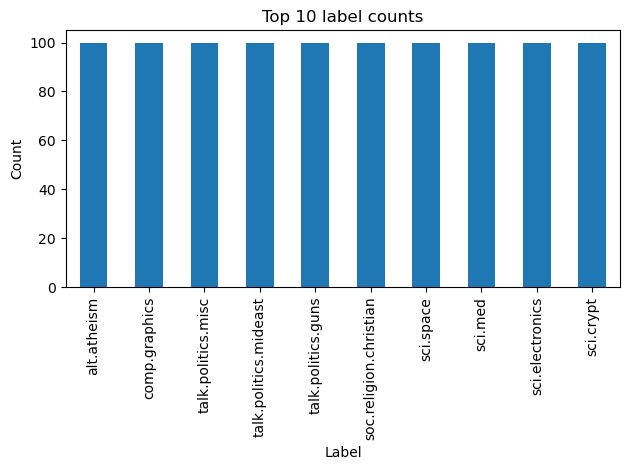

In [8]:
#plt.figure(figsize=(10,5))
label_counts.head(10).plot(kind='bar')
plt.title("Top 10 label counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Exploratory Data Analysis:
    * No presence of any null values.
    * 2000 entries with object datatype having equal label counts.

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [9]:
# 3) Text length features (char count and word count)
df['text_str'] = df['Data'].astype(str)
df['char_count'] = df['text_str'].apply(len)
df['word_count'] = df['text_str'].apply(lambda x: len(x.split()))
print("\nText length statistics:")
print(df[['char_count','word_count']].describe())


Text length statistics:
         char_count    word_count
count   2000.000000   2000.000000
mean    2324.978000    314.166000
std     3590.560226    539.210333
min      425.000000     31.000000
25%     1147.000000    127.000000
50%     1605.500000    194.000000
75%     2374.500000    319.000000
max    62290.000000  10384.000000


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* KEY SATATISTICS :
    * Count of the number of observations in the dataset is 2000 word counts.
    * The average text length (mean) has about 2325 characters and 314 words.
    * A high standard deviation from the mean suggests that the text lengths are widely spread out and not clustered around the mean, indicating wide range of the text lengths
    * Shortest text in the collection is 425 characters and 31 words.
    * Longest text in the collection is 62290 characters and 10384 words

* Majority texts are relatively short, exceptionaly long texts significantly inflating the mean and standard deviation to form the skewed distributions.

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

#### Preprocess the data by cleaning the text (removing punctuation, converting to lowercase, etc.), tokenizing, and removing stopwords.
* Removing common newsgroup/email headers (like - Path:, Newsgroups:, From:, Subject:, Xref:, Message-ID:, etc.)
* Converting the text to  lowercaeg, remoinge URLs, emails, numbers, punctuation, extra whitespacs if any.
* T tokenization with reg
* R- reingove stopwordwithtry Nrds)

In [10]:
#!pip install nltk

### Getting Stopwords from nltk corpus

In [11]:
# Use nltk library to create tokens
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords as nltk_sw
stopset = set(nltk_sw.words('english'))
print(stopset)

{'wasn', 'each', 'did', 'out', 'more', "haven't", 'then', 'ma', 'shouldn', 'too', 'was', 'other', 'does', "won't", 'were', "mustn't", 'their', 'any', 'me', 'over', 'from', 'only', 'than', 'mustn', "shan't", 'won', 'very', 'am', 'both', 's', 'isn', 'shan', 'and', 'own', 'we', 'an', 'yourself', 'have', 'doesn', 'her', 'in', 'do', 'few', "it's", 'between', "couldn't", 'a', 'being', 'how', 'ours', 'this', 'hadn', 'them', 'been', "needn't", "you'll", 'again', "doesn't", 'into', 'these', 'down', 'just', "should've", "aren't", 'on', 'at', 'him', 'his', 'most', "hasn't", 'what', "wouldn't", 'once', 'it', 'all', 'same', 'off', "wasn't", 'before', 'such', 'yourselves', 'why', 'so', 'hers', 'themselves', 've', 'by', 'above', 'ourselves', 'with', "didn't", 'during', 'the', 'y', 'its', 'but', 'she', 'can', 'after', 'where', 'himself', 'couldn', "hadn't", 'herself', 'whom', 'which', 'are', 'mightn', "you've", 'needn', 'o', 'there', 'didn', 'below', "mightn't", 't', 'our', 'wouldn', 'those', 'until',

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Getting the stopwords corpus using nltk library
* Appending text_str, char_count, ad word_count in dataset for each document.

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

#### Preprocessing Text

In [12]:
df.head(5)

,Data,Labels,text_str,char_count,word_count
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,5972,910
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,1336,163
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,3116,450
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,15910,2732
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,3264,438


##### Checking how often the dataset contains the Email headers / news headers in the dataset

In [13]:
# Regex for Common headers found in email /news datasets 
header_pattern = r'(?mi)^(Path|Newsgroups|From|Subject|Xref|Message-ID|Lines|Organization|Reply-To|Date|To|Cc|Bcc|Content-Type|MIME-Version|Received):'

In [14]:
## Importing Regex library
import re

# Getting all headers in a dataset
header_counts = {}

for text in df['Data'].dropna():
    matches = re.findall(header_pattern, text)
    for m in matches:
        header_counts[m] = header_counts.get(m, 0) + 1
        

In [15]:
header_counts.items()

dict_items([('Path', 2000), ('From', 2016), ('Newsgroups', 2004), ('Subject', 2044), ('Date', 2001), ('Organization', 1930), ('Lines', 1995), ('Message-ID', 2000), ('Xref', 574), ('Reply-To', 292), ('To', 8), ('Mime-Version', 2), ('Content-Type', 2), ('to', 1)])

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* Getting the list of common header patterns available in the dataset using regular expressions library 

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [16]:
def preprocess_text(text, stopwords=stopset, min_token_len=2):
    
    # Checknig the wheather the passed text is string otherwise converting it into string format
    if not isinstance(text, str):
        text = str(text)

    # Removing common headers like Path, From, Newsgroups, Subject etc using regex library.
    text = re.sub(r'(?m)^(Path|Newsgroups|From|Subject|Date|Xref|Message-ID|Lines|Organization|Reply-To|To|Mime-Version|Content-Type):.*\n?', ' ', text)
    # Converting to the lowercase
    text = text.lower()
    # Removing URLs and www. using regex
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # Removing emails using regex
    text = re.sub(r'\S+@\S+', ' ', text)
    # Removing numbers if any
    text = re.sub(r'\d+', ' ', text)
    # Removing punctuation (keep whitespace & word characters)
    text = re.sub(r'[^\w\s]', ' ', text)
    # Removing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

     # Tokenization (alphabetic tokens form)
    tokens = re.findall(r'\b[a-z]+\b', text)

    # Removing stopwords and short tokens
    tokens = [t for t in tokens if t not in stopwords and len(t) >= min_token_len]
    return " ".join(tokens)
    

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* A custom function to preprocess the text data with the parameters,
    * text - input text to be preprocessed
    * stopwords - a list of set of common words (like from nltk.corpus.stopwords)
    * min_token_len - The minimum length of the word (token) to keep. Any word shorter than 2 characters will likely be removed.
* Checking the wheather the passed text is string otherwise converting it into string format
* Removing common headers like Path, From, Newsgroups, Subject etc using regex library.
* Converting text to the lowercase
* Removing URLs and www. using regex
* Removing emails using regex
* Removing numbers if any
* Removing punctuation (keep whitespace & word characters)
* Removing whitespace
* Tokenization (alphabetic tokens form)
* Removing stopwords and short tokens
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [17]:
##### Applying Preprocessing and creating new column 'clean_text'

df['clean_text'] = df['text_str'].apply(preprocess_text)
# Comparing original text and cleaned text
display(df[['text_str','clean_text']].head(6))

,text_str,clean_text
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,distribution world references nntp posting hos...
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,sender nntp posting host okcforum osrhe edu ne...
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,keywords slander calumny references nntp posti...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,references article mathew writes writes articl...
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,sender references article jim halat writes art...
5,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,references nntp posting host squick eitech com...


In [18]:
df['clean_word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
print(df['clean_word_count'].describe())

count    2000.000000
mean      144.763000
std       293.902756
min         0.000000
25%        51.000000
50%        84.000000
75%       145.000000
max      5645.000000
Name: clean_word_count, dtype: float64


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* KEY SATATISTICS (Clean Text):
    * Count of the number of observations in the dataset is 2000 word counts.
    * The average text length (mean) has about 144 words.
    * A high standard deviation from the mean suggests that the text lengths are widely spread out and not clustered around the mean.
    * Shortest text in the collection is 0 words.
    * Longest text in the collection is 5645 words

<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [19]:
df.head(4)

,Data,Labels,text_str,char_count,word_count,clean_text,clean_word_count
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,5972,910,distribution world references nntp posting hos...,392
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,1336,163,sender nntp posting host okcforum osrhe edu ne...,70
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,3116,450,keywords slander calumny references nntp posti...,211
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,15910,2732,references article mathew writes writes articl...,1218


###  TF-IDF vectorization (prepare features for Naive Bayes)

##### Perform feature extraction to convert text data into a format that can be used by the Naive Bayes model, using techniques such as TF-IDF.

In [20]:
vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, ngram_range=(1,2))
# Fitting TF IDF vectirizer on clean text

X = vectorizer.fit_transform(df['clean_text'])
y = df['Labels'].values

print(f"TF-IDF Shape : {X.shape}")

TF-IDF Shape : (2000, 8510)


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* KEY SATATISTICS (Clean Text):
    * max_df - Removing very frequent words
    * min_df - Removing very rare words 
    * ngram_range - Considering unigrams & bigrams
        
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [21]:
# Showing top 20 features by IDF, smallest idf -> most common across docs
feature_names = np.array(vectorizer.get_feature_names_out())
idf = vectorizer.idf_
top_common = feature_names[np.argsort(idf)[:20]]
print("\nTop 20 common features (by smallest IDF):")
print(top_common)


Top 20 common features (by smallest IDF):
['references' 'sender' 'writes' 'article' 'posting' 'host' 'nntp'
 'nntp posting' 'posting host' 'one' 'would' 'like' 'know' 'get' 'edu'
 'also' 'think' 'news' 'people' 'time']


### Train Test Split (Sratification to understand the class balance and the potential for rare classes.)

In [22]:
label_counts = df['Labels'].value_counts()
print("\nLabel counts (summary):", label_counts.describe().to_dict())

stratify_arg = df['Labels'] if (label_counts >= 2).all() else None
if stratify_arg is None:
    print("Some labels have fewer than 2 samples — performing non-stratified split.")
else:
    print("All labels have >=2 samples — performing stratified split.")


Label counts (summary): {'count': 20.0, 'mean': 100.0, 'std': 0.0, 'min': 100.0, '25%': 100.0, '50%': 100.0, '75%': 100.0, 'max': 100.0}
All labels have >=2 samples — performing stratified split.


<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* The dataset is perfectly balanced across all 20 unique categories (labels)
* The dataset have 20 labels and each label has exactly 100 samples
* The standard deviation is zero, there is no variation.
        
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify_arg, random_state=42)
print("Train Shape : ", X_train.shape, "Test Shape : ", X_test.shape)

Train Shape :  (1600, 8510) Test Shape :  (400, 8510)


### Multinomial Naive Bayes

In [24]:
# Training MultinialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [25]:
## Predicting on test set 
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy : {acc:.4f}\n")
print("Classification Report (Multilabel) :")
print(classification_report(y_test, y_pred, zero_division=0))

Test Accuracy : 0.7500

Classification Report (Multilabel) :
                          precision    recall  f1-score   support

             alt.atheism       0.67      0.70      0.68        20
           comp.graphics       0.63      0.85      0.72        20
 comp.os.ms-windows.misc       0.75      0.75      0.75        20
comp.sys.ibm.pc.hardware       0.44      0.55      0.49        20
   comp.sys.mac.hardware       0.77      0.50      0.61        20
          comp.windows.x       0.82      0.70      0.76        20
            misc.forsale       0.80      0.80      0.80        20
               rec.autos       0.77      0.85      0.81        20
         rec.motorcycles       0.77      0.85      0.81        20
      rec.sport.baseball       0.85      0.85      0.85        20
        rec.sport.hockey       0.95      1.00      0.98        20
               sci.crypt       0.87      1.00      0.93        20
         sci.electronics       0.76      0.65      0.70        20
              

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* The evaluation for multiclass clasfiication model classifying correctly around on 400 test samples, with 75% test accuracy score generally cosidered good suggesting the model is performing better than the random guessing.
* The macro average takes the unweighted average is 75% close to the accuracy reinforces overall good performance.
* The weighted average F1 score same as macro average depicts the model is consisten performance across the balanced dataset.
* Top F1 Scores (High performing classes):
    * rec.sport.hockey - with 95% precision and recall 1, with a very good perfomance as 0.98 as F1 score, that means the evry hockey related item is correctly identified and almost non hockey was misclassified as hockey.
    * Another category is sci.crypt with 0.93 F1 score and recall a 1.
    * Other classes also do have a good F1 scores in between 0.81 to 0.87, like rec.autos,  rec.motorcycle, rec.sport.baseball, talk.politics.mideast etc.
* Low F1 score (Weak performing classes):
    * With low presicion 0.44 and low recall 0.55 and low F1 score 0.49. For the class comp.sys.ibm.pc.hardware, The model misclassified the content as something else and its often wrong.
    * There sre some classes with very low recall and F1 scores, with overall low perfomance, like talk.religion.misc, talk.politics.misc, comp.sys.mac.hardware, talk.politics.guns.

***Conclusion :***
* The model is performing well with 75% of accuracy with overall satisfactory performance on balanced test set.
* The primary area of improvement is addressing low recall and low F1 score classes and focus on extracting more features from these poorly performing classes to boost their recall and precision to get the good F1 scores and overall good accuracy.s.
        
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

### Sentiment Analysis

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

In [27]:
# VADER lexicon is download
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
# Initialize VADER analyzer
sia = SentimentIntensityAnalyzer()

In [29]:
# Computing sentiment Scores

sentiment_scores = df['Data'].apply(sia.polarity_scores)

In [30]:
# Converting dict results into separate columns

sentiment_df = pd.DataFrame(list(sentiment_scores))
df = pd.concat([df, sentiment_df], axis=1)

In [31]:
df

,Data,Labels,text_str,char_count,word_count,clean_text,clean_word_count,neg,neu,pos,compound
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,5972,910,distribution world references nntp posting hos...,392,0.142,0.768,0.090,-0.9966
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,1336,163,sender nntp posting host okcforum osrhe edu ne...,70,0.011,0.890,0.099,0.8856
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,3116,450,keywords slander calumny references nntp posti...,211,0.169,0.787,0.044,-0.9969
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,15910,2732,references article mathew writes writes articl...,1218,0.188,0.720,0.092,-0.9999
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,3264,438,sender references article jim halat writes art...,174,0.035,0.867,0.097,0.9821
...,...,...,...,...,...,...,...,...,...,...,...
1995,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,talk.religion.misc,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,5263,782,references nntp posting host ap mchp sni de ar...,317,0.068,0.840,0.092,0.9706
1996,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,1771,208,references article red herring writes fbi clai...,81,0.024,0.909,0.067,0.8327
1997,Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...,talk.religion.misc,Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...,2192,219,references sender usenet news system article b...,81,0.011,0.896,0.093,0.9387
1998,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,talk.religion.misc,Xref: cantaloupe.srv.cs.cmu.edu talk.religion....,3197,469,references followup talk religion misc alt sex...,215,0.066,0.790,0.144,0.9914


In [32]:
# Classifying sentiment category

def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= 0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['compound'].apply(get_sentiment_label)

In [33]:
print("\n Sentiment Results :")
display(df[['Data', 'compound', 'Sentiment']].head(10))


 Sentiment Results :


,Data,compound,Sentiment
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,-0.9966,Negative
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,0.8856,Positive
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,-0.9969,Negative
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,-0.9999,Negative
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,0.9821,Positive
5,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,0.9856,Positive
6,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,-0.8271,Negative
7,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,0.7817,Positive
8,Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...,0.8523,Positive
9,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,0.9603,Positive


#### Overall Sentiment Distribution

In [34]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
Positive    1334
Negative     666
Name: count, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_13500\1580940822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])


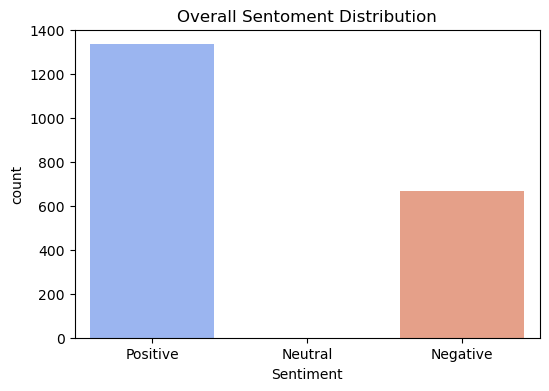

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title("Overall Sentoment Distribution")
plt.show()

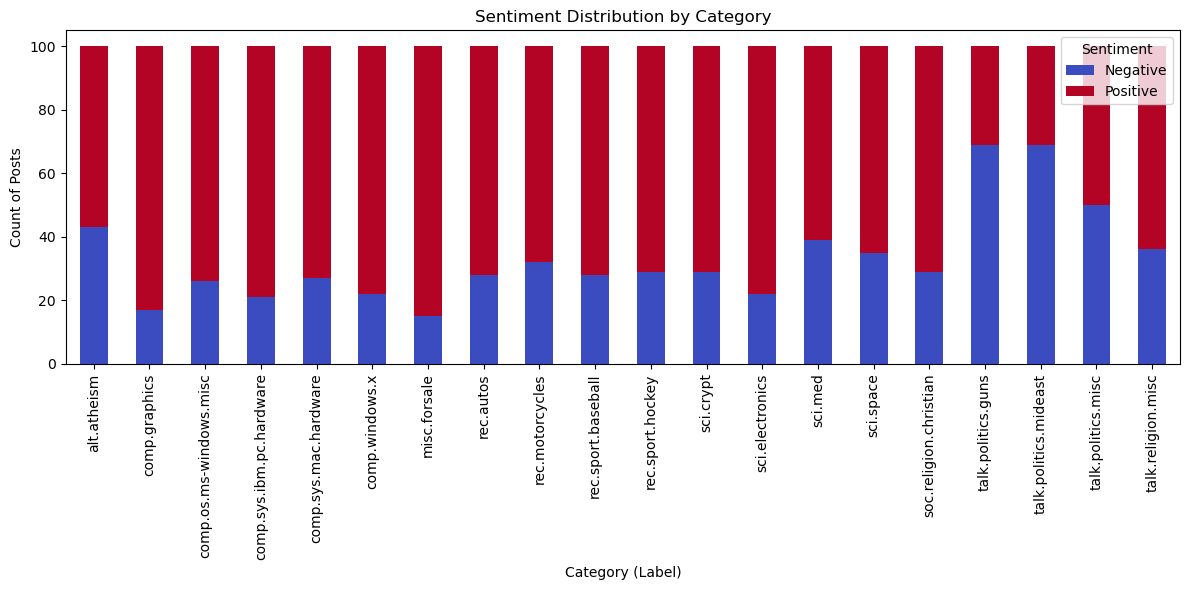

Sentiment,Negative,Positive
Labels,,
alt.atheism,43,57
comp.graphics,17,83
comp.os.ms-windows.misc,26,74
comp.sys.ibm.pc.hardware,21,79
comp.sys.mac.hardware,27,73
comp.windows.x,22,78
misc.forsale,15,85
rec.autos,28,72
rec.motorcycles,32,68


In [36]:
sentiment_by_label = df.groupby(['Labels', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_label.plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title("Sentiment Distribution by Category")
plt.xlabel("Category (Label)")
plt.ylabel("Count of Posts")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Display table
display(sentiment_by_label)

<p style="background-color:#008000;color:#fff;font-size:18px;padding:10px"> Observations :</p>
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">

* The goal of the task is performed with the sentiment analysis on the blog post dataset, and categorized them into the Positive, Neutral and Negative sentiments.
* The tool vader lexicon is used to calculate the weighted average Compound Sentiment Score.
* The standard thresholds classifies the sentiment scores as positive, neutral and negative as 
    * Positive Sentiment : compound score >= 0.05
    * Negative Sentiment : compound score <= -0.05
    * Neutral Sentiment  : -0.05 < compound score < 0.05
* From the overall sentiments distributions we can see, from total of 2000 sentiments there are 1334 are positive sentiments, 666 are negative sentiments, and no neutral sentiments present.
    
<hr style="height:3px;border:none;color:#008000;background-color:#008000;">